# Analysing species extinction probability

**Housekeeping**

In [1]:
library(car)
library(ggplot2)
library(InformationValue)
library(MASS)
library(plyr)
library(pscl)
library(reshape2)
library(tidyverse)

Loading required package: carData
Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.1.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.3.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::recode()    masks car::recode()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::select()    masks M

**Read in data**

In [2]:
species_composition = read.table("../../../data/amplicon/rel_abund.txt", 
                                 sep = "\t",
                                 header = T,
                                 row.names = 1)

metadata = read.table("../../../data/amplicon/meta.txt",
                      sep = "\t",
                      header = T,
                      row.names = 1)


species_composition$ID = rownames(species_composition)
metadata$ID = rownames(metadata)

# merge species composition with metadata

data = merge(species_composition, metadata, all = T)

# inspect

head(data)

ID,Citrobacter_koseri_HAMBI_1287,Elizabethkingia_meningoseptica_HAMBI_1875,Aeromonas_caviae_HAMBI_1972,Pseudomonas_chlororaphis_HAMBI_1977,Sphingobacterium_spiritivorum_HAMBI_1896,Comamonas_testosteroni_HAMBI_403,Agrobacterium_tumefaciens_HAMBI_105,Stenotrophomonas_maltophilia_HAMBI_2659,Myroides_odoratus_HAMBI_1923,⋯,Chitinophaga_filiformis_HAMBI_1966,Thermomonas_haemolytica_HAMBI_2467,Moraxella_canis_HAMBI_2792,Acinetobacter_lwoffii_HAMBI_97,Pseudomonas_putida_HAMBI_6,Chitinophaga_sancti_HAMBI_1988,Immigration,Streptomycin,Replicate,Day
T12_I0_AB0_REP1,0.02044547,0.1950614,0.2713066,0.1746159,0.002609835,0.3269056022,5.283067e-05,0.00000000,0.0000000000,⋯,0,0,0,0,0.0000000000,0,0,0,1,48
T12_I0_AB0_REP2,0.18956445,0.3435331,0.1276586,0.3231926,0.003979660,0.0002653106,8.843688e-05,0.00000000,0.0000000000,⋯,0,0,0,0,0.0000000000,0,0,0,2,48
T12_I0_AB0_REP3,0.15960167,0.2744808,0.1932894,0.2805813,0.087605975,0.0000000000,0.000000e+00,0.00000000,0.0006279998,⋯,0,0,0,0,0.0000000000,0,0,0,3,48
T12_I0_AB0_REP4,0.16116394,0.3383399,0.1873889,0.1478108,0.081355907,0.0047695225,6.591421e-03,0.00000000,0.0109758265,⋯,0,0,0,0,0.0000000000,0,0,0,4,48
T12_I0_AB0_REP5,0.17480631,0.2856506,0.2308473,0.1852274,0.017277655,0.0133419144,5.990247e-03,0.04039704,0.0019802470,⋯,0,0,0,0,0.0000000000,0,0,0,5,48
T12_I0_AB0_REP6,0.24414392,0.2605325,0.2364341,0.1691945,0.018537243,0.0043815302,1.365015e-02,0.00000000,0.0129760701,⋯,0,0,0,0,0.0001263903,0,0,0,6,48


Edit data frame

In [3]:
# remove ID column and convert to narrow format

data = melt(data[,-1], id.vars = c("Replicate", "Streptomycin", "Immigration", "Day"))

# rename columns

colnames(data) = c("Replicate", "Streptomycin", "Immigration", "Day", "Species", "Abundance")

# convert to long format over time

data = spread(data, Day, Abundance)

# rename columns

colnames(data) = c("Replicate", "Streptomycin", "Immigration", "Species", "ABUND16", "ABUND32", "ABUND48")

# add sample ID

data$ID = paste(data$Streptomycin, data$Immigration, data$Replicate, sep = "_")

# inspect

head(data)

Replicate,Streptomycin,Immigration,Species,ABUND16,ABUND32,ABUND48,ID
1,0,0,Citrobacter_koseri_HAMBI_1287,0.1762295,0.06857143,0.020445468,0_0_1
1,0,0,Elizabethkingia_meningoseptica_HAMBI_1875,0.2254098,0.41142857,0.195061389,0_0_1
1,0,0,Aeromonas_caviae_HAMBI_1972,0.2131148,0.17142857,0.271306608,0_0_1
1,0,0,Pseudomonas_chlororaphis_HAMBI_1977,0.2254098,0.20000000,0.174615921,0_0_1
1,0,0,Sphingobacterium_spiritivorum_HAMBI_1896,0.0204918,0.02285714,0.002609835,0_0_1
1,0,0,Comamonas_testosteroni_HAMBI_403,0.0000000,0.00000000,0.326905602,0_0_1


Compute species extinction

_Let's define extinction as the presence of the strain prior to the antibiotic pulse and the absence afterwards_

In [4]:
data$Extinction = ifelse(data$ABUND16 > 0 & data$ABUND32 == 0 & data$ABUND48 == 0, 1, 0)

# extract relevant columns

data = na.omit(data[,c("Species", "Streptomycin", "Immigration", "Replicate", "Extinction")])

# inspect

nrow(data[data$Extinction == 1,]) # 146 cases of extinction
head(data)

[1] 146

Species,Streptomycin,Immigration,Replicate,Extinction
Citrobacter_koseri_HAMBI_1287,0,0,1,0
Elizabethkingia_meningoseptica_HAMBI_1875,0,0,1,0
Aeromonas_caviae_HAMBI_1972,0,0,1,0
Pseudomonas_chlororaphis_HAMBI_1977,0,0,1,0
Sphingobacterium_spiritivorum_HAMBI_1896,0,0,1,0
Comamonas_testosteroni_HAMBI_403,0,0,1,0


Merge extinction data with phenotypic data

In [5]:
phenotypes = read.table("../../../data/amplicon/phenotypic_traits.txt",
                        sep = "\t",
                        header = T)

phenotypes$Species = rownames(phenotypes)
phenotypes = phenotypes[phenotypes$Species %in% unique(data$Species),]
data = na.omit(merge(data, phenotypes, by = "Species", all = T))

# inspect

head(data)

Species,Streptomycin,Immigration,Replicate,Extinction,K_growth,r_growth,Streptomycin_MIC,Aminoglycoside_resistance_gene,Carbon_sources
Citrobacter_koseri_HAMBI_1287,4,0,2,0,0.3877448,0.6190797,3.178054,1,16
Citrobacter_koseri_HAMBI_1287,16,0,7,0,0.3877448,0.6190797,3.178054,1,16
Citrobacter_koseri_HAMBI_1287,128,0,1,0,0.3877448,0.6190797,3.178054,1,16
Citrobacter_koseri_HAMBI_1287,16,0,2,0,0.3877448,0.6190797,3.178054,1,16
Citrobacter_koseri_HAMBI_1287,16,1,3,0,0.3877448,0.6190797,3.178054,1,16
Citrobacter_koseri_HAMBI_1287,4,0,5,0,0.3877448,0.6190797,3.178054,1,16


Convert log MIC to original MIC

In [6]:
data$MIC_orig = exp(data$Streptomycin_MIC)

# inspect

head(data)

Species,Streptomycin,Immigration,Replicate,Extinction,K_growth,r_growth,Streptomycin_MIC,Aminoglycoside_resistance_gene,Carbon_sources,MIC_orig
Citrobacter_koseri_HAMBI_1287,4,0,2,0,0.3877448,0.6190797,3.178054,1,16,24
Citrobacter_koseri_HAMBI_1287,16,0,7,0,0.3877448,0.6190797,3.178054,1,16,24
Citrobacter_koseri_HAMBI_1287,128,0,1,0,0.3877448,0.6190797,3.178054,1,16,24
Citrobacter_koseri_HAMBI_1287,16,0,2,0,0.3877448,0.6190797,3.178054,1,16,24
Citrobacter_koseri_HAMBI_1287,16,1,3,0,0.3877448,0.6190797,3.178054,1,16,24
Citrobacter_koseri_HAMBI_1287,4,0,5,0,0.3877448,0.6190797,3.178054,1,16,24


**Stats**

In [7]:
# binary response variable --> logistic regression (i.e. binomial glm)

# convert immigration and streptomycin to factor

data$Immigration = factor(data$Immigration)
data$Streptomycin = factor(data$Streptomycin)

# let's start from model including all experimental treatments

M1 = glm(Extinction ~ Immigration +
         Streptomycin +
         Species +
         MIC_orig,
         family = binomial, 
         data = data)

# let's use AIC to select best model among all interactions

M2 = stepAIC(M1, 
             scope=list(upper = ~Immigration*
                            Streptomycin*
                            Species*MIC_orig,
                            lower = ~1),
             trace = FALSE)

anova(M2, test = "Chi")

# antibiotic, immigration and species all affect extinction probability
# the effect of antibiotic depends on the species

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,1647,962.8900,NA
Immigration,1,27.30667,1646,935.5834,1.736115e-07
Streptomycin,3,22.25471,1643,913.3286,5.773580e-05
Species,25,165.82606,1618,747.5026,9.619778e-23
Immigration:Streptomycin,3,7.51922,1615,739.9834,5.706667e-02


**Sketch model fit**

In [8]:
MyData = ddply(data, 
                .(Immigration, Species, Streptomycin),
                summarize)
ilink = family(M2)$linkinv
MyData = cbind(MyData, predict(M2, MyData, type = "link", se.fit = TRUE)[1:2])
MyData = transform(MyData, Fitted = ilink(fit), Upper = ilink(fit + (2 * se.fit)),
                Lower = ilink(fit - (2 * se.fit)))

colnames(MyData)[1] = "Immigration"
MyData$Immigration = factor(MyData$Immigration, 
                            levels = c("0", "1"),
                            labels = c("No immigration",
                                       "Immigration"))
MyData$Streptomycin = factor(MyData$Streptomycin, 
                            levels = c("0", "4", "16", "128"),
                            labels = c("No",
                                       "Low",
                                       "Intermediate",
                                       "High"))

MyData$Species = factor(MyData$Species, 
                       levels = unique(MyData$Species))

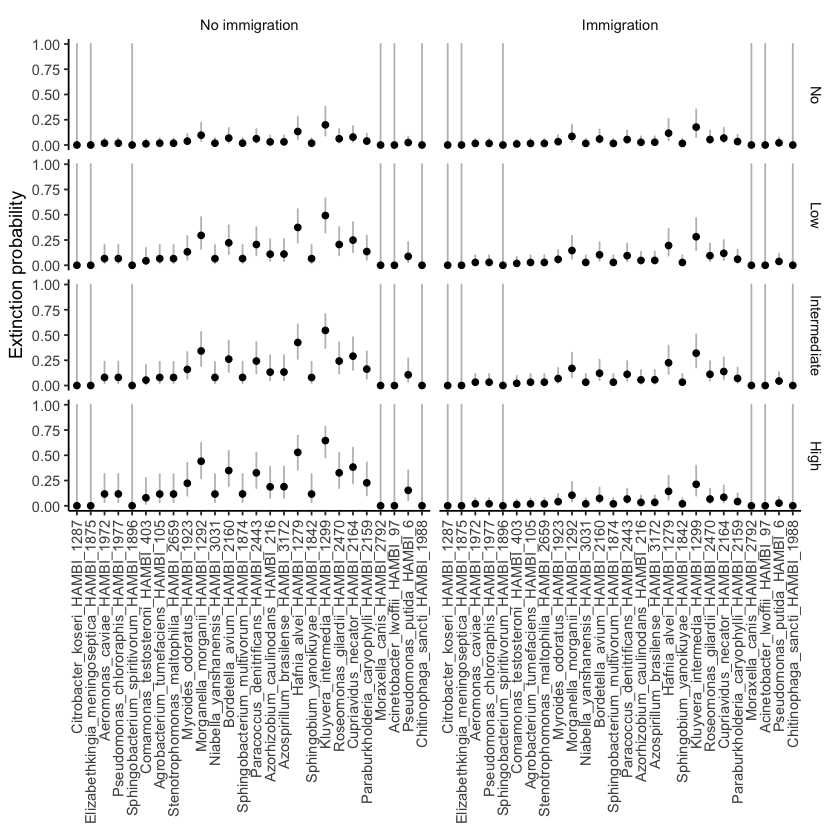

In [9]:
ggplot(MyData, aes(x=Species, y=Fitted)) + 
    geom_errorbar(aes(ymin=Lower, ymax=Upper), width=.1, colour = "grey") +
    geom_point() +
    facet_grid(Streptomycin~Immigration) +
    ylab("Extinction probability") +
    theme_classic() +
    scale_color_manual(values = c("black", "#522639","#8f4364","#cd6090")) + 
    labs(colour = "Intrinsic resistance level") +
    theme(axis.text.x  = element_text(angle = 90, vjust = 0.5, hjust = 1),
          strip.background = element_rect(colour = "white", fill = "white"),
          axis.title.x = element_blank())

**Save plot**

In [10]:
# ggsave("../../../manuscript/figures/extinction_probability.pdf", width = 10)